<a href="https://colab.research.google.com/github/George090872/Computer-Vision/blob/main/Lab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Image Filtering in Frequency Domain

<b> Objective: </B> During this lab, the goal is to become familiar with image filtering in frequency domain in Python.

<b> Acknowledgment: </B> <BR />  
1- https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_transforms/py_fourier_transform/py_fourier_transform.html<BR />






Test to see that OpenCV functions are around 3x faster than Numpy functions. This can be tested for inverse FFT also.

In [ ]:
import cv2
import numpy as np
img = cv2.imread('girl.tif', 0)  # Replace 'girl.tif' with your image path
# NumPy FFT
%timeit np.fft.fft2(img)

# OpenCV FFT
%timeit cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)

# NumPy Inverse FFT
f = np.fft.fft2(img)  # Calculate FFT first
%timeit np.fft.ifft2(f)

# OpenCV Inverse FFT
dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT) # Calculate DFT first
%timeit cv2.idft(dft)

14.4 ms ± 2.71 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.18 ms ± 56 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
15.5 ms ± 2.9 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.56 ms ± 69.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


**Explanation:** As seen in the comparison above, when FFT and inverse FFT was run on both OpenCv and Numpy, Using FFT, OpenCV was approximately 6x faster compared to Numpy, and for Inverse FFT, OpenCV was approximately 4x fatser than using Numpy

#### Using DFT to up-sample an image
1. Let’s use the girl gray-scale image.
2. First double the size of the by padding zero rows/columns at every alternate positions.
3. Use FFT followed by an LPF.
4. Finally use IFFT to get the output image.


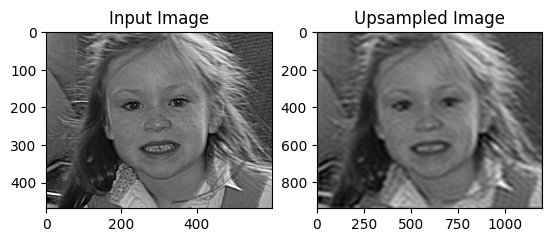

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

#Load the image
img = cv2.imread('girl.tif', 0)  # Replace 'girl.tif' with the actual image path

#Double the size with zero padding at alternate positions
rows, cols = img.shape
new_rows, new_cols = rows * 2, cols * 2
upsampled_img = np.zeros((new_rows, new_cols), dtype=img.dtype)
upsampled_img[::2, ::2] = img

#Apply FFT and LPF
dft = cv2.dft(np.float32(upsampled_img), flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

# Create a low-pass filter mask (e.g., Gaussian)
crow, ccol = new_rows // 2, new_cols // 2
mask = np.zeros((new_rows, new_cols, 2), np.uint8)
mask[crow - 30:crow + 30, ccol - 30:ccol + 30] = 1  # Adjust filter size as needed

# Apply the mask
filtered_dft = dft_shift * mask

# 4. Apply IFFT to get the output image
f_ishift = np.fft.ifftshift(filtered_dft)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])

# Display the results
plt.subplot(121), plt.imshow(img, cmap='gray'), plt.title('Input Image')
plt.subplot(122), plt.imshow(img_back, cmap='gray'), plt.title('Upsampled Image')
plt.show()

**Explanation**: The grayscale image is first loaded using `cv2.imread` and applying zero-padding to upsample it by doubling its dimensions. A Discrete Fourier Transform (DFT) is applied (`cv2.dft`), shifted to the center (`np.fft.fftshift`), and filtered with a low-pass filter to retain low frequencies. The filtered DFT is then shifted back and reconstructed into the spatial domain using an Inverse DFT (`cv2.idft`), with the magnitude extracted for the final image. Finally, the original and upsampled images are compared using Matplotlib.


Apply Gaussian and Laplacian filtering in the frequency domain on the grayscale image of the girl and plot the filtered image in both the frequency and spatial domains.

<ipython-input-17-df0ea0eeef49>:86: RuntimeWarning: divide by zero encountered in log
  plt.imshow(20*np.log(np.abs(laplacian_filtered_dft[:,:,0])), cmap='gray')  #Log scale


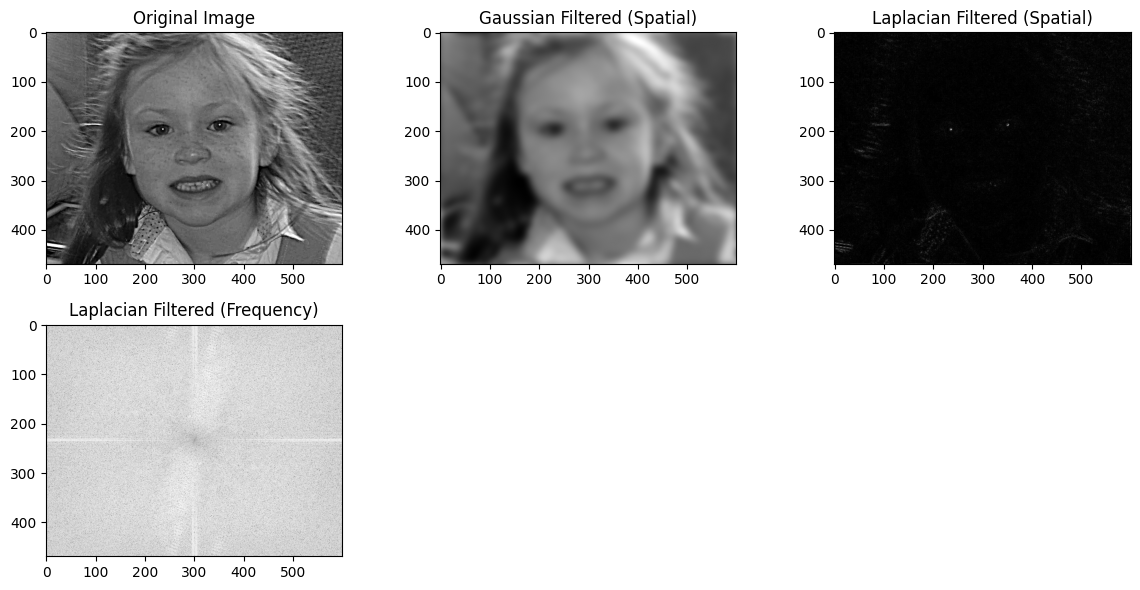

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the image
img = cv2.imread('girl.tif', 0)

#Gaussian Filtering

# a) DFT
dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

# b) Create Gaussian Filter Mask
rows, cols = img.shape
crow, ccol = rows // 2, cols // 2
sigma = 10  # Adjust the standard deviation for the Gaussian kernel

# Create Gaussian kernel with correct dimensions
gaussian_kernel = cv2.getGaussianKernel(ksize=rows, sigma=sigma)
gaussian_kernel = np.outer(gaussian_kernel, gaussian_kernel.T)

# Resize the Gaussian kernel to match the image shape
gaussian_kernel_resized = cv2.resize(gaussian_kernel, (cols, rows))

gaussian_mask = np.zeros((rows, cols, 2), np.float32)
gaussian_mask[:, :, 0] = gaussian_kernel_resized
gaussian_mask[:, :, 1] = gaussian_kernel_resized

# c) Apply Gaussian Mask
gaussian_filtered_dft = dft_shift * gaussian_mask

# d) Inverse DFT
f_ishift = np.fft.ifftshift(gaussian_filtered_dft)
gaussian_filtered_img = cv2.idft(f_ishift)
gaussian_filtered_img = cv2.magnitude(gaussian_filtered_img[:, :, 0], gaussian_filtered_img[:, :, 1])


#Laplacian Filtering

# a) DFT (already calculated above)

# b) Create Laplacian Filter Mask
laplacian_kernel = np.array([[0, 1, 0],
                            [1, -4, 1],
                            [0, 1, 0]], dtype=np.float32)

laplacian_dft = np.fft.fft2(laplacian_kernel, s=(rows, cols))  # Pad the kernel to match image size
laplacian_dft_shift = np.fft.fftshift(laplacian_dft)
laplacian_mask = np.zeros((rows, cols, 2), np.float32)
laplacian_mask[:,:,0] = np.abs(laplacian_dft_shift)
laplacian_mask[:,:,1] = np.abs(laplacian_dft_shift)

# c) Apply Laplacian Mask
laplacian_filtered_dft = dft_shift * laplacian_mask


# d) Inverse DFT
f_ishift = np.fft.ifftshift(laplacian_filtered_dft)
laplacian_filtered_img = cv2.idft(f_ishift)
laplacian_filtered_img = cv2.magnitude(laplacian_filtered_img[:, :, 0], laplacian_filtered_img[:, :, 1])



# Plotting the results
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(231)
plt.imshow(img, cmap='gray')
plt.title('Original Image')

# Gaussian Filtered Image (Spatial domain)
plt.subplot(232)
plt.imshow(gaussian_filtered_img, cmap='gray')
plt.title('Gaussian Filtered (Spatial)')


# Laplacian Filtered Image (Spatial domain)
plt.subplot(233)
plt.imshow(laplacian_filtered_img, cmap='gray')
plt.title('Laplacian Filtered (Spatial)')

# Laplacian Filtered Spectrum
plt.subplot(234)
plt.imshow(20*np.log(np.abs(laplacian_filtered_dft[:,:,0])), cmap='gray')  #Log scale
plt.title('Laplacian Filtered (Frequency)')


plt.tight_layout()
plt.show()

**Explanation**: The Gaussian kernel is resized using `cv2.resize` to match the image dimensions (rows, cols), ensuring compatibility for element-wise multiplication. The resized kernel is then used to create the `gaussian_mask`, resolving any broadcasting errors.

In [ ]:
img = cv2.imread('girl.tif', 0)
rows, cols = img.shape
print(f'rows =', rows, f'     cols =', cols)

nrows = cv2.getOptimalDFTSize(rows)
ncols = cv2.getOptimalDFTSize(cols)
print(f'nrows =', nrows, f'    ncols =', ncols)

rows = 469      cols = 600
nrows = 480     ncols = 600
